# GCGC Analysis tool

## Welcome to GCGC : Garbage Collection Graph Collector! 

This notebook will automatically generate a list of plots for analysis of your garbage collection file. You can go onto modify or expand on these automatically generated plots. Tested in python 3.9.5.

First, in the cell below, fill in both labels and filepaths as a list of strings. 

In [1]:
### List of files to analyze. You can use the wildcard to gather files in one directory for one run. 
filepaths = ["../../datasets/SerialGC.log",
             "../../datasets/ParallelGC.log",
             "../../datasets/G1GC.log",
             "../../datasets/ShenandoahGC.log",
             "../../datasets/ZGC.log.*", # wild card captures both ZGC.log.0 and ZGC.log.1 files
             "../../datasets/GenZGC.log",
             "../../datasets/GraalVM.log"]

### Describe the files above. Each index in the list corresponds to one GC log run.   
labels = ["Serial",
          "Parallel",
          "G1",
          "Shenandoah",
          "ZGC",
          "GenZGC",
          "GraalVM"]

### Zeros all starting times for all parsed log files. Set to false to disbale this feature          
zero_times = True

# Used for development. Changes made in other files are reflected here.
%load_ext autoreload
%autoreload 2

# Import all required packages onto local computer
import sys
!{sys.executable} -m pip install matplotlib -q # plotting 
!{sys.executable} -m pip install pandas -q # store gc event data
!{sys.executable} -m pip install numpy -q # computations on gc event data



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


The following cell parses the cells, and creates a list of gc event logs, called `gc_event_dataframes`. No action is required.

In [2]:
files = []
import sys
import os.path
sys.path.append("../../")
sys.path.append("../")     
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12, 7] #  Size of figures created from plots by default [12,7]
from src.read_log_file import get_gc_event_tables, get_file_names_wildcard, zero_start_times
# Get all files
for filepath in filepaths:
    files.append(get_file_names_wildcard(filepath))

# Parse all files
gc_event_dataframes = get_gc_event_tables(files, zero_times, ignore_crashes= False)

# Check that there are the correct number of labels.
if len(gc_event_dataframes) != len(labels):
    print("Error: Labels do not have same length as collected data")

# The notebook is broken down into 5 analysis sections

- `A` : Latency analysis

- `B` : Heap Analysis

- `C` : Code Cache Analysis

- `D` : Metaspace Analysis

- `E` : Summary of trends

# Section A: Latency Analysis
---


## 1. STW Pauses during program runtime: 

This plot finds all times the live application paused due to garbage collection, and plots pauses in milliseconds vs. the application's runtime.
The duration and frequencies of these pauses are important to note when viewing this plot. This should create a scatter plot, which will appear inline.

Notice, the cell below contains a filter for pauses_only. 

        filter_by = pauses_only

This filter is applied to each row of the `gc event log`, and graphs only the rows which return `True` from the filter function. 

For more information on this plot, view the [help documentation](./README.md#1-stw-pauses-during-program-runtime) for this plot:


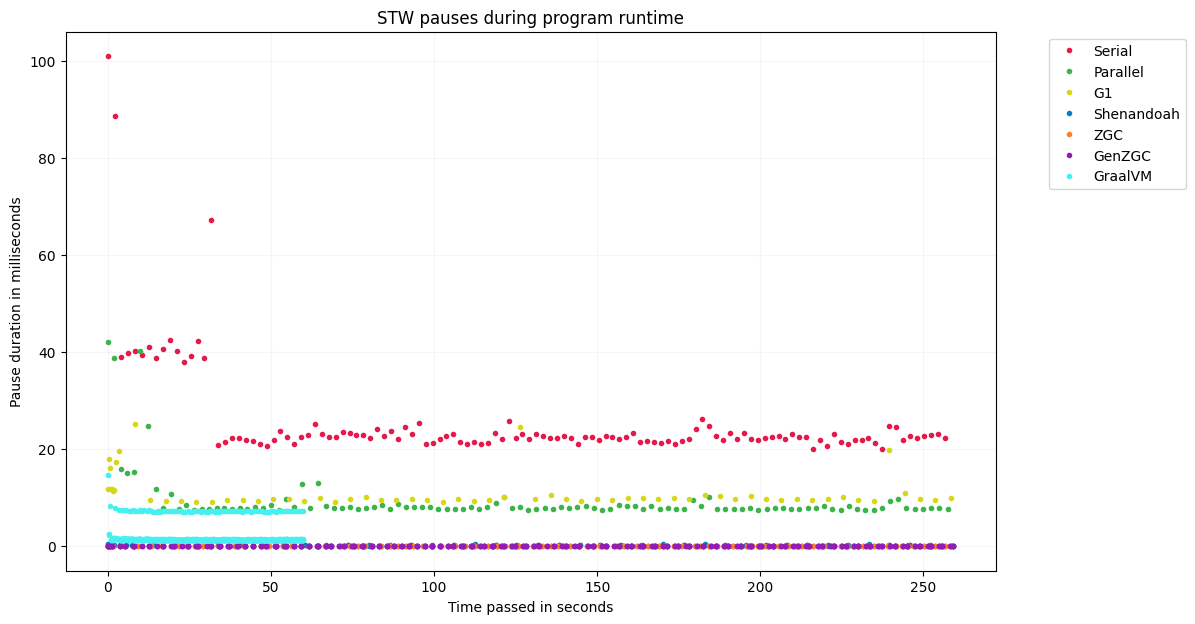

In [3]:
from src.graphing.plotting import *

# Define a filter for searching for pauses in a gc_event_dataframe row. Will be reused throughout notebook
def pauses_only(row):
    if "EventType" in row:
        if row["EventType"] == "Pause":
            return True
    return False 

# Apply the filter, and create a plot
plot = plot_scatter(gc_event_dataframes, filter_by = pauses_only, labels=labels)

# Set the style and details on the plot
_ = plot.set_title("STW pauses during program runtime")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Pause duration in milliseconds")
plot.grid(alpha = 0.1)

## 2. STW Pauses during program runtime, group by EventName

This plot shows all stop the world pauses due to GC activity, but now sorts them by the Event Name. This is an example of the optional parameter `group_by`, which is usable on every plotting or table function. In this case, we use

        group_by = "EventName" 

to put all unique values in the EventName column of each `gc event dataframe` in their own grouping. 
 A more complete explanation of group by can be found in the [documentation here](./README.md#2-stw-pauses-during-program-runtime-group-by-eventname)

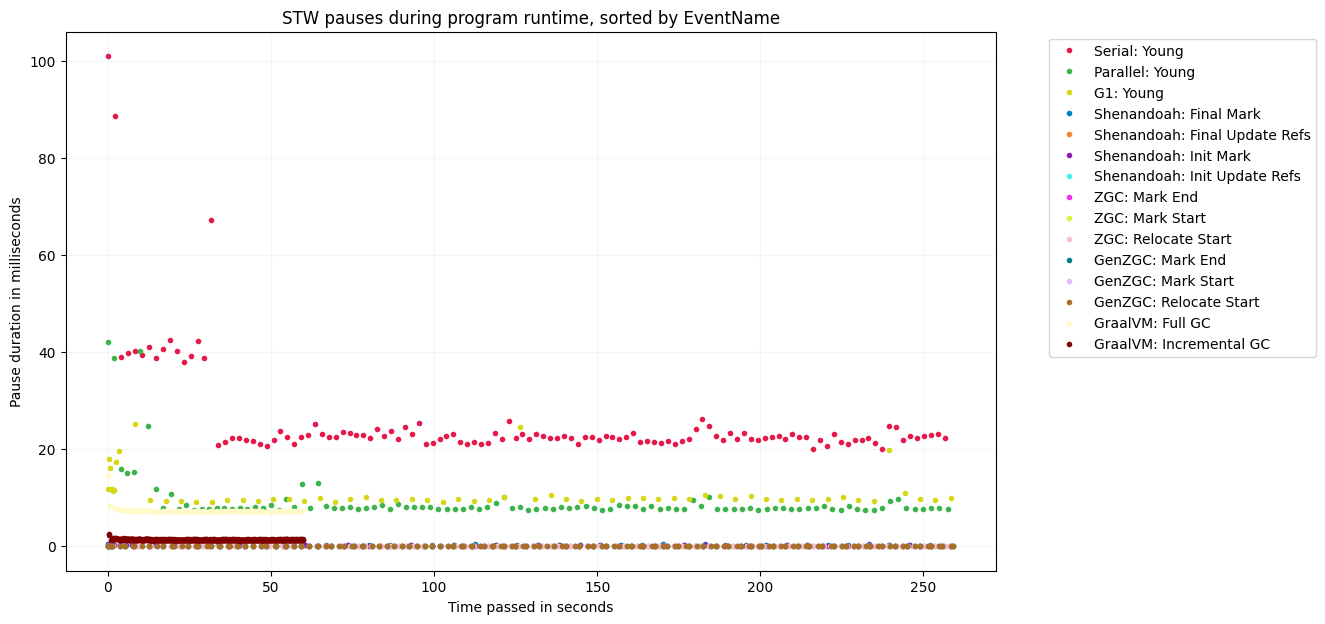

In [4]:
plot = plot_scatter(gc_event_dataframes, filter_by = pauses_only, labels=labels, group_by = "EventName")
_ = plot.set_title("STW pauses during program runtime, sorted by EventName")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Pause duration in milliseconds")
plot.grid(alpha = 0.1)

############################################################################################################
# Note: The following code block can be added to enable logarithmic scaling for the plot generated.
############################################################################################################
# Set log scale
# from matplotlib.ticker import ScalarFormatter
# plot.set_yscale("log") 
# # plot.yaxis.set_major_formatter(ScalarFormatter()) # This has a known bug. Makes values below 1 displayed as zero on y axis scale. 

## 3. Latency Heatmaps, Linear
A heatmap will group all events into different time intervals, and then display the frequency of pauses in those time intervals. 

### Important! You must manually set the time range for this plot. This was done to allow for easy comparison of heatmaps visually. More information can be [found here](./README.md#3-latency-heatmaps-linear)

Note: The warning message generated by `MatplotlibDeprecationWwarning` can be ignored. Changes to resolve it will be added soon.

Serial Warning: 116 values lies outside the provided range for latency. Max value outside range: 101.063
Parallel Warning: 4 values lies outside the provided range for latency. Max value outside range: 42.134
G1 Warning: 2 values lies outside the provided range for latency. Max value outside range: 25.224


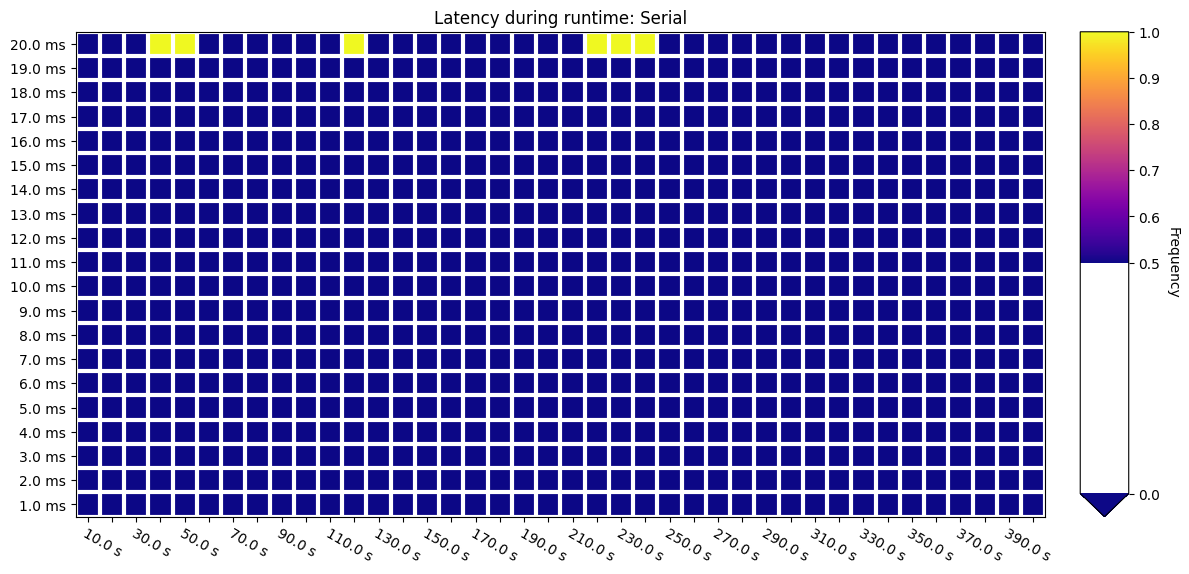

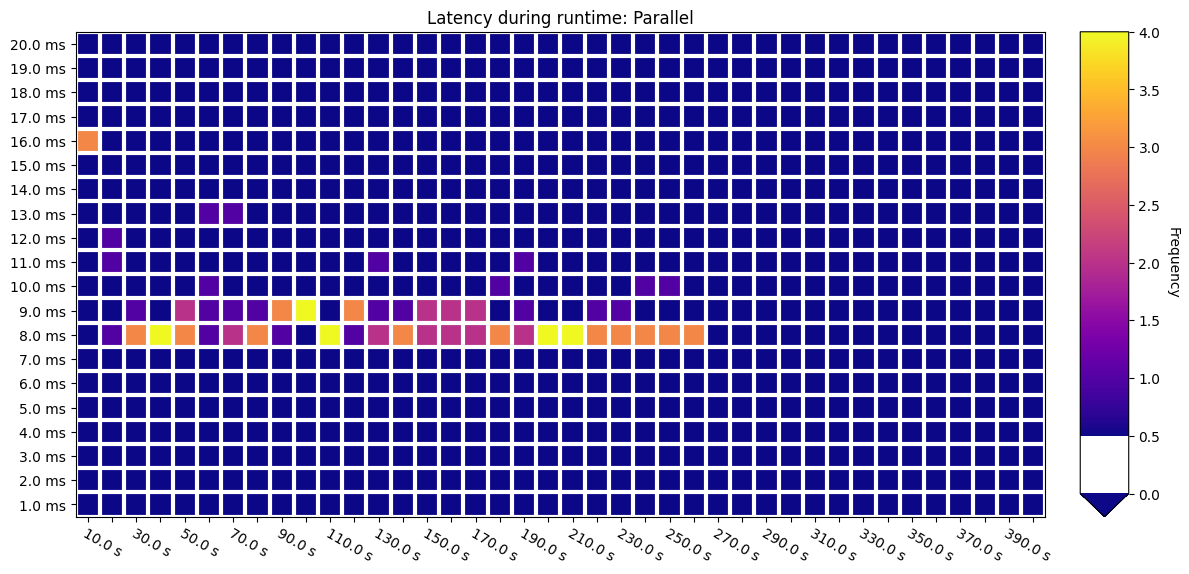

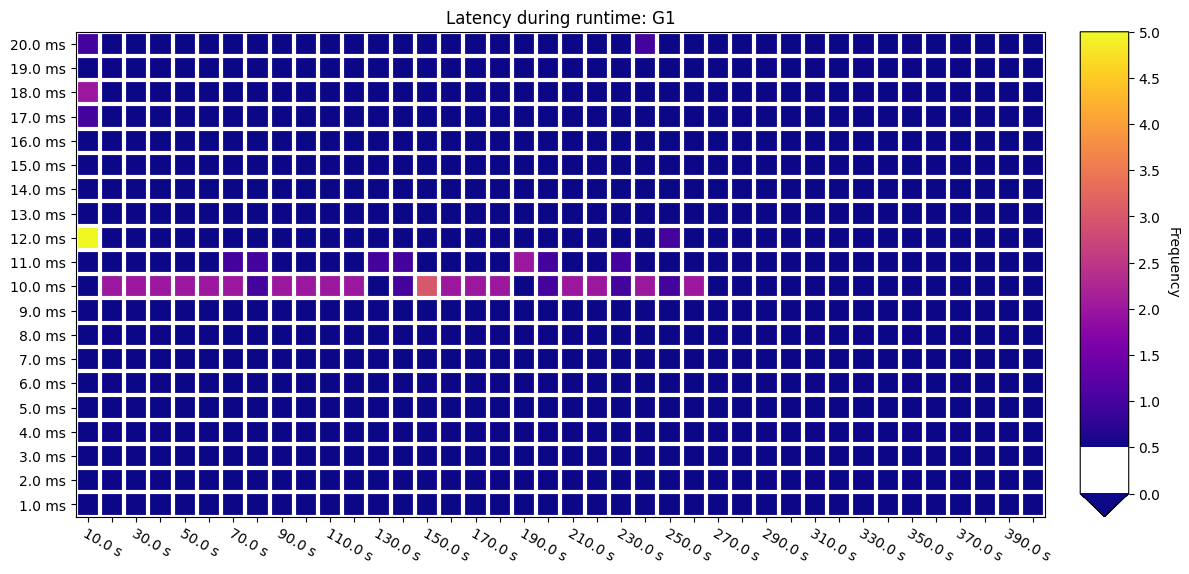

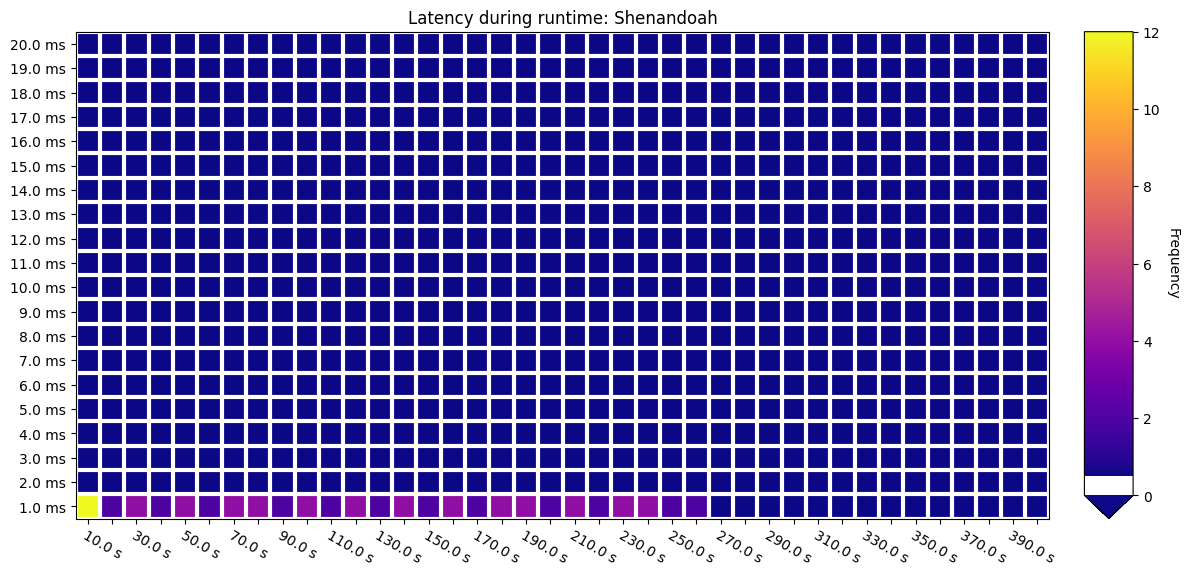

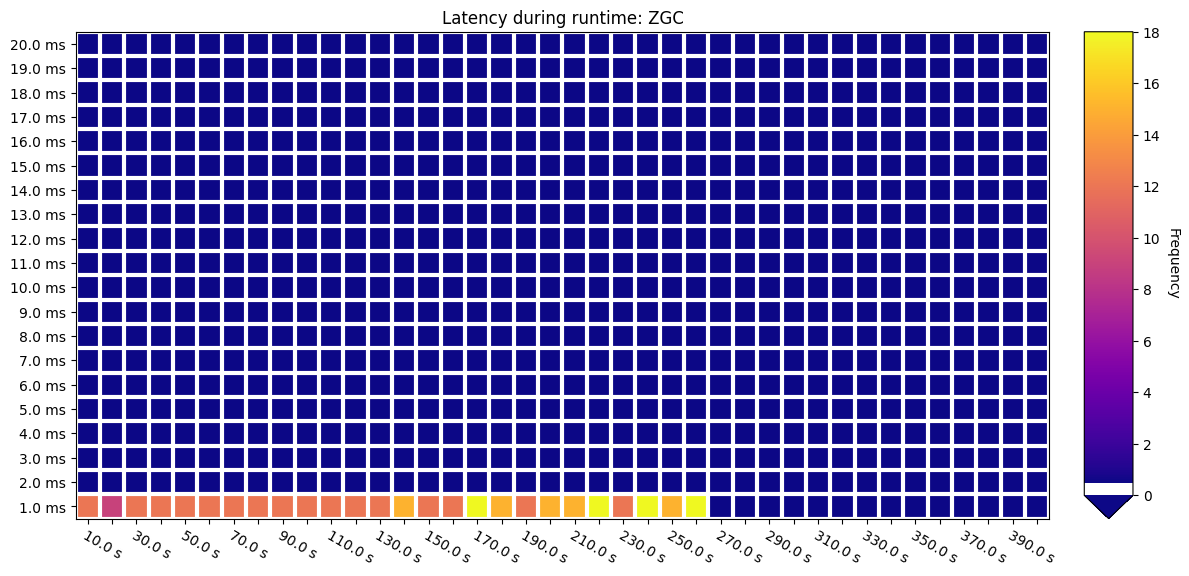

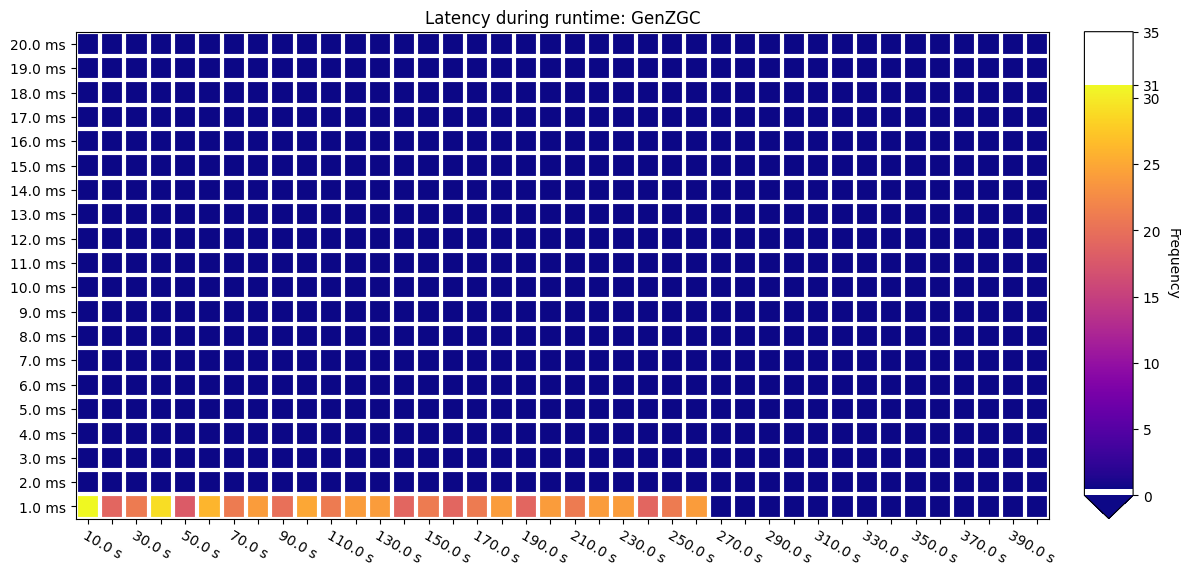

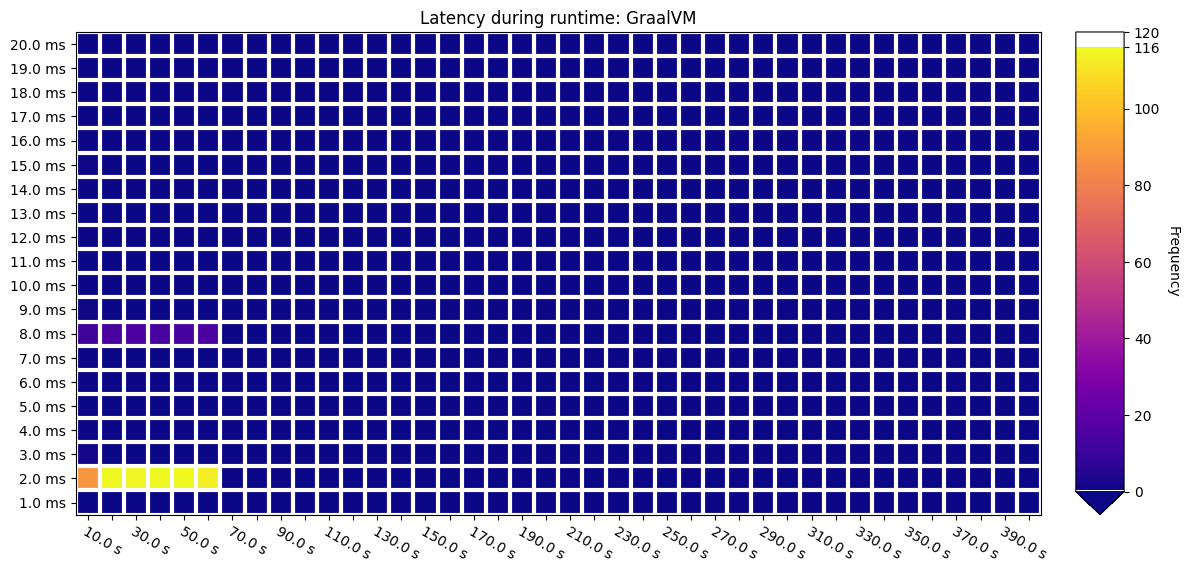

In [5]:
from src.graphing.plotting import plot_heatmaps

number_x_intervals  = 40
number_y_intervals  = 20
duration_x_interval = 10 # seconds
duration_y_interval = 1 # milliseconds

# Dimensions packs the parameters into one object
dimensions = [number_x_intervals,
              number_y_intervals,
              duration_x_interval,
              duration_y_interval] 

frequency_ticks = False
plot_heatmaps(gc_event_dataframes,
            dimensions, 
            filter_by = pauses_only, 
            labels=labels,
            frequency_ticks = frequency_ticks)

## 4. Logarithmic heatmaps

Logarithmic heatmap, good for use on concurrent collectors such as Shenandoah or ZGC, especially when comparing them to non-fully concurrent collectors such as ParallelGC, or G1GC.

### Important: You must set the time range, interval duration, and logarithmic base scaling yourself. See [documentation](./README.md#4-logarithmic-heatmaps) for more help.


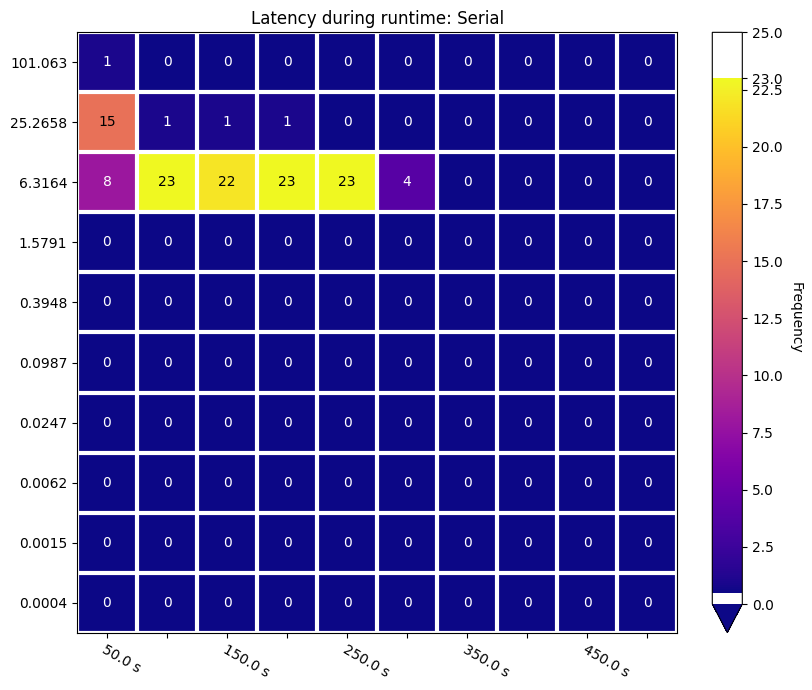

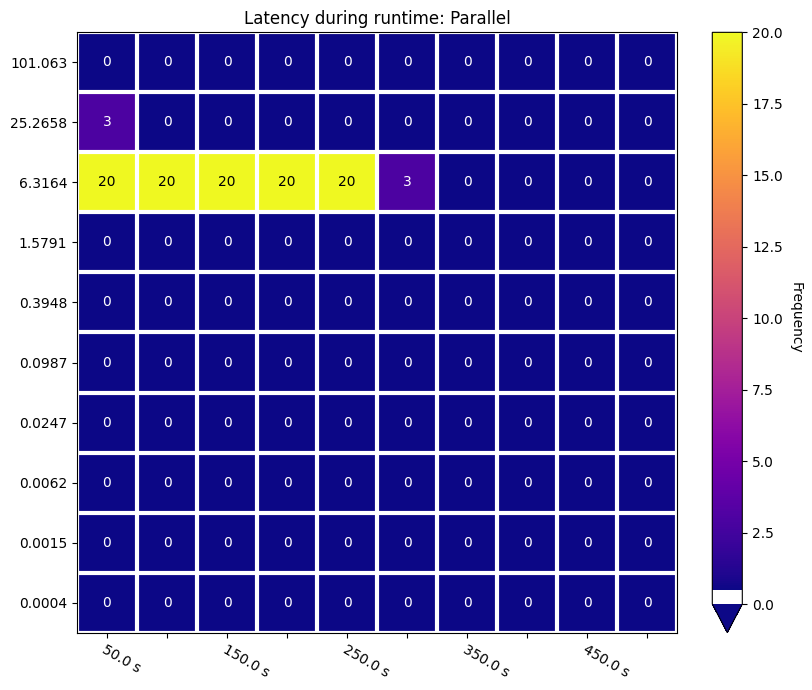

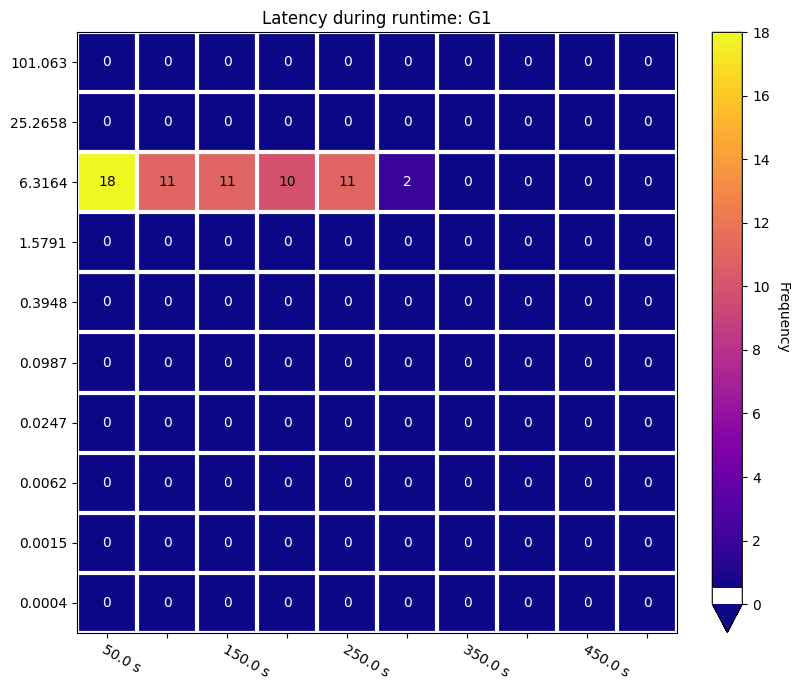

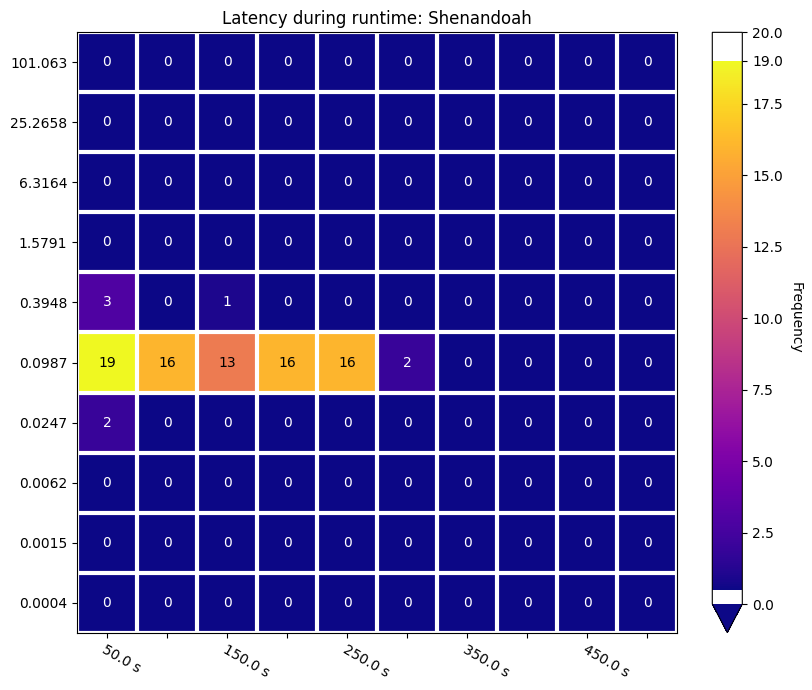

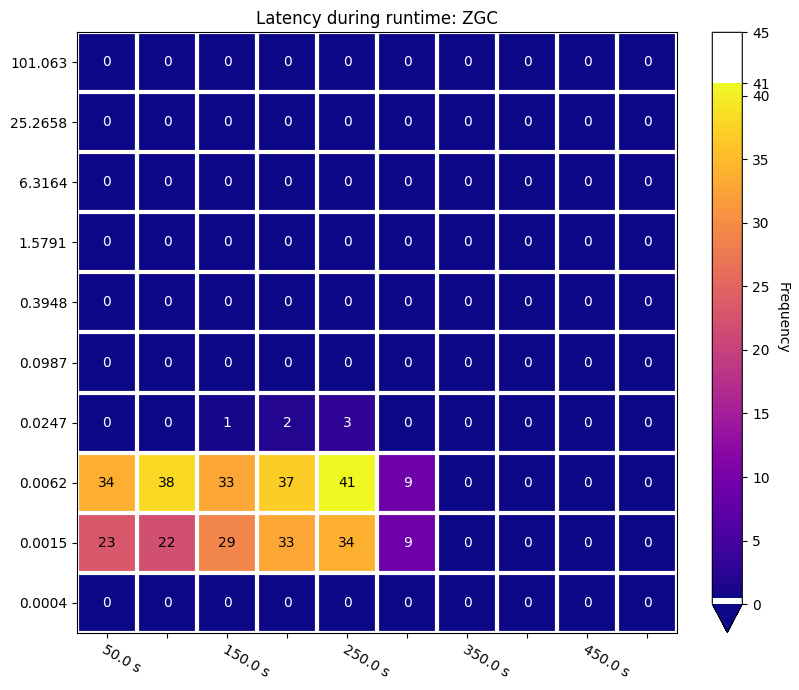

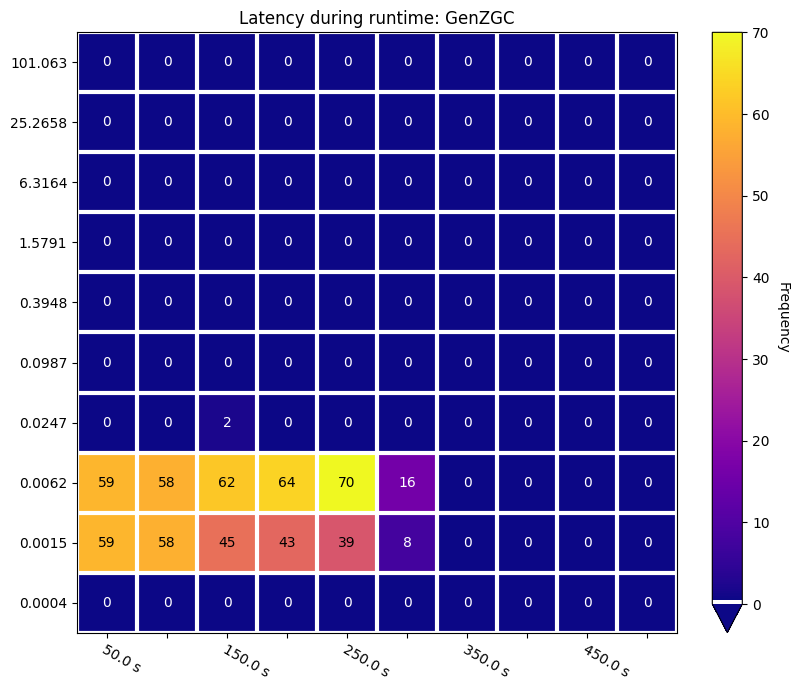

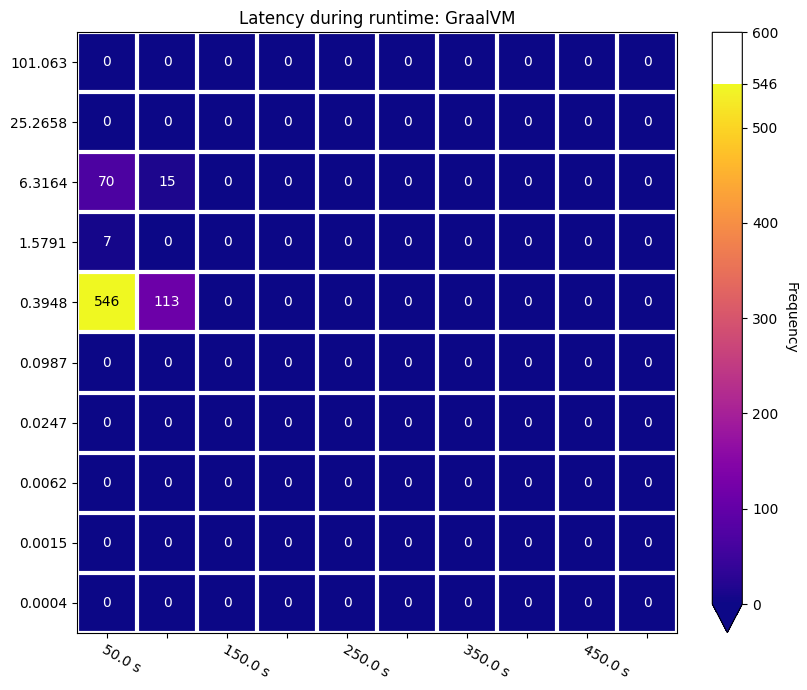

In [6]:
from src.graphing.plotting import plot_heatmaps_logarithmic
dimensions = [10, 10, 50, 4]
# [ x bucket count, y bucket count, x duration count, base]
frequency_ticks = True
plot_heatmaps_logarithmic(gc_event_dataframes, dimensions, 
                         filter_by = pauses_only, labels=labels, 
                         frequency_ticks = frequency_ticks)


## 5. Latency percentiles over time intervals

Given a list of percentiles, plot the pause latencies in each given time interval duration (in seconds) based on these. Generates 1 line per percentile listed. Read more about customizing the presentation of the chart with lines/scatter and colors here:  [help](./README.md#5-latency-percentiles-over-time-intervals)

Percentiles plotted:  [99.9, 90, 50]


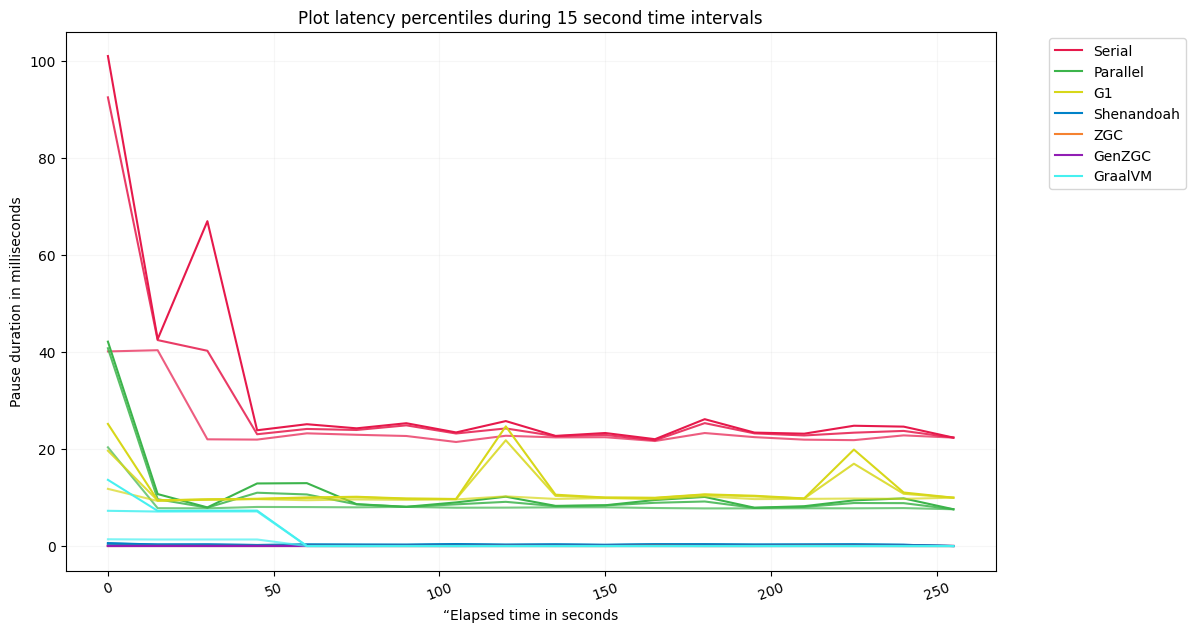

In [7]:
from src.graphing.plotting import plot_percentile_intervals
interval_duration = 15 
percentiles = [99.9, 90, 50] # Choose the percentiles to be plotted.
plot = plot_percentile_intervals(gc_event_dataframes, 
                                filter_by = pauses_only,
                                interval_duration = interval_duration ,
                                labels = labels,
                                percentiles = percentiles,
                                different_colors= False, # Set to true to have a unique color for each line on graph
                                line_graph = True)
plot.set_ylabel("Pause duration in milliseconds")
plot.set_xlabel("“Elapsed time in seconds")
plot.set_title("Plot latency percentiles during "+ str(interval_duration) + " second time intervals")
plot.grid(alpha = 0.1)
_ = plt.xticks(rotation = 20)
print("Percentiles plotted: ", percentiles)

## 6. Sum of pause durations over intervals
Finds the total time the application spent paused during different regions of times. Produces simlar plot to the gc plot generated by Java Flight Recorder.
[help](./README.md#6-sum-of-pause-durations-over-intervals)

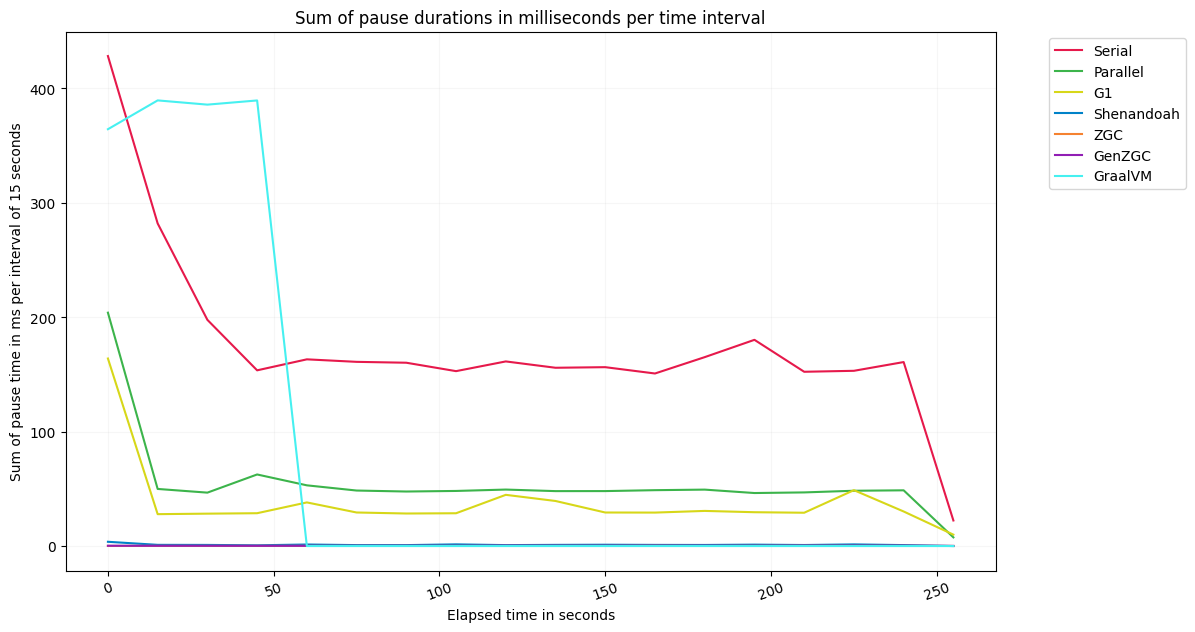

In [8]:
from src.graphing.plotting import plot_sum_pause_intervals

interval_duration = 15
plot = plot_sum_pause_intervals(gc_event_dataframes,
                                filter_by = pauses_only,
                                interval_duration = interval_duration, 
                                labels = labels,
                                line_graph = True )
_ = plot.set_title("Sum of pause durations in milliseconds per time interval")
plot.set_ylabel("Sum of pause time in ms per interval of " + str(interval_duration) + " seconds", )
plot.set_xlabel("Elapsed time in seconds")
plot.grid(alpha = 0.1)
_ = plt.xticks(rotation = 20)

# Section B: Heap analysis
---

## 7. Percentage of heap full after global GC

Calculates the percentage of the heap that is full after a global garbage collection runs. This helps determining the heap size configuration.

A "global" or "major" collection traverses the entire heap and detects every live object, thus providing relatively up-to-date information about the extent of the live set, whereas a "minor" or "young" collection only traverses part of the heap.

Global collections are identified by the following labels.
- Serial: include "Full", exclude "Young".
- Parallel: include "Full", exclude "Young".
- GraalVM: include "Full", exclude "Incremental".
- G1: include "Full" and "Young combined with "Mixed", exclude "Young combined with "Normal".
- Generational ZGC: include "Major" exclude "Minor".
- Shenandoah and ZGC: all collections are global.

Note: column must be set to "HeapPercentFull". HeapPercentFull is calculated in the pre-analysis processing, by taking the "Heap After GC" metric, and the "MaxHeapsize" metric if present, and calculating the percent full as a float.
More help [can be found here](./README.md#7-percentage-of-heap-full-after-global-gc)


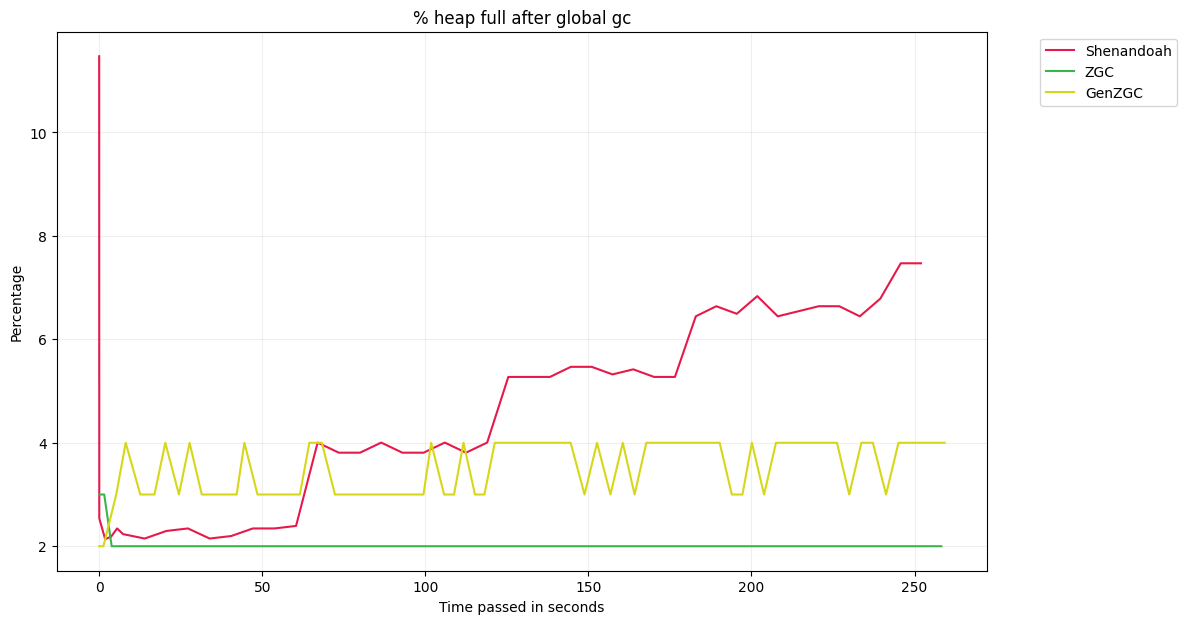

In [26]:
# Create filter
def heap_percent_full_filter(row):
    if "HeapPercentFull" in row:
        if row["HeapPercentFull"] != None:
            return True
    return False
plot = plot_line(gc_event_dataframes, 
                        filter_by = heap_percent_full_filter,
                        labels = [label for label in labels],
                        column = "HeapPercentFull")
plot.set_title("% heap full after global gc")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Percentage")
plot.grid(alpha = 0.2)


## 8. Heap before and after GC
Generates a plot for the heap space used in MB before garbage collection, and after garbage collection. Note the change in the Y axis when viewing these plots, it is typical for them not to align. 
Optional: You are welcome to plot these two graphics onto the same table, using the following additional lines of code:
    
    unique_colors = [...] # fill this in
    plot = plot_line(...) # generates plot1: heap before gc
    plot = plot_line(... , plot = plot, colors = unique_colors) # adds the data for heap_after_gc to plot1. Make sure to add unique colors.

More information can be [found here](./README.md#8-heap-before-and-after-gc)

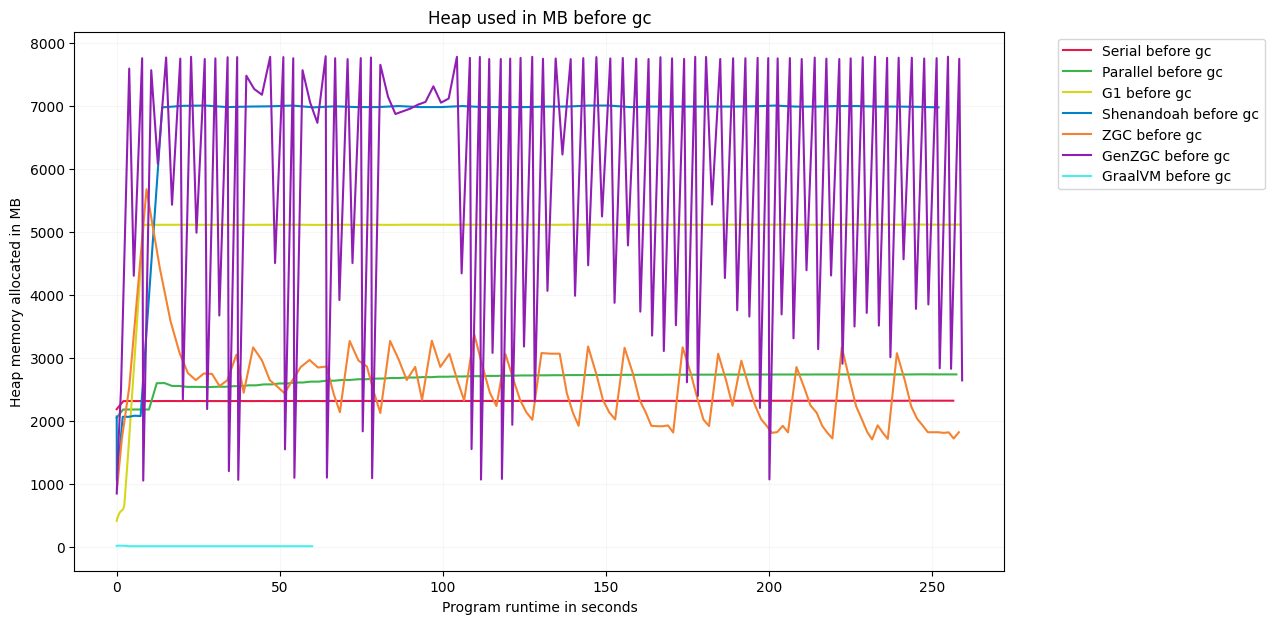

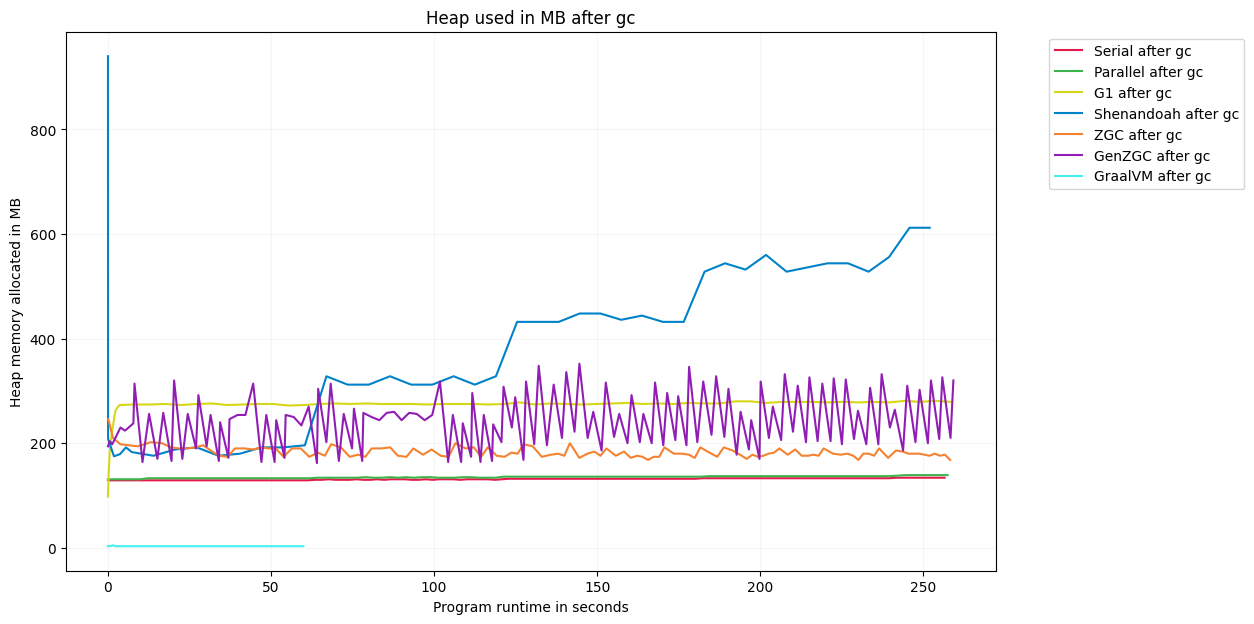

In [10]:
from src.graphing.plotting import plot_scatter, plot_line

# Sort the values in the dataframe, for the case where many associated log files for one run are grouped, and a line plot is generated.
for df in gc_event_dataframes:
    if "TimeFromStart_seconds" in df:
        df.sort_values(by="TimeFromStart_seconds", axis=0,inplace=True)

def before_gc_filter(row):
    if "HeapBeforeGC" in row:
        if row["HeapBeforeGC"] != None:
            return True
    return False

def after_gc_filter(row):
    if "HeapAfterGC" in row:
        if row["HeapAfterGC"] != None:
            return True
    return False

# Plot before
#   NOTE: if you would rather see a scatter plot, replace the function call to "plot_line(...)"
#         with a function call to "plot_scatter(...)"
plot = plot_line(gc_event_dataframes,
            group_by = None, 
            filter_by = before_gc_filter,
            labels = [label + " before gc" for label in labels], 
            column = "HeapBeforeGC")
plot.set_title("Heap used in MB before gc")
plot.set_ylabel("Heap memory allocated in MB")
plot.set_xlabel("Program runtime in seconds")
plot.grid(alpha = 0.1)

# Plot After
plot = plot_line(gc_event_dataframes,
            group_by = None, 
            filter_by = after_gc_filter,
            labels = [label + " after gc" for label in labels],
            column = "HeapAfterGC")
            
plot.set_title("Heap used in MB after gc")
plot.set_ylabel("Heap memory allocated in MB")
plot.set_xlabel("Program runtime in seconds")
plot.grid(alpha = 0.1)

## 9. MB reclaimed during program runtime

Calculates the amount of reclaimed bytes using the before / after GC collection values from the GC log file. This may be slightly inaccurate at times, for collectors which have MORE heap usage after GC, due to high allocation rate, and low MB reclaimed. 
[help](./README.md#9-mb-reclaimed-during-program-runtime)

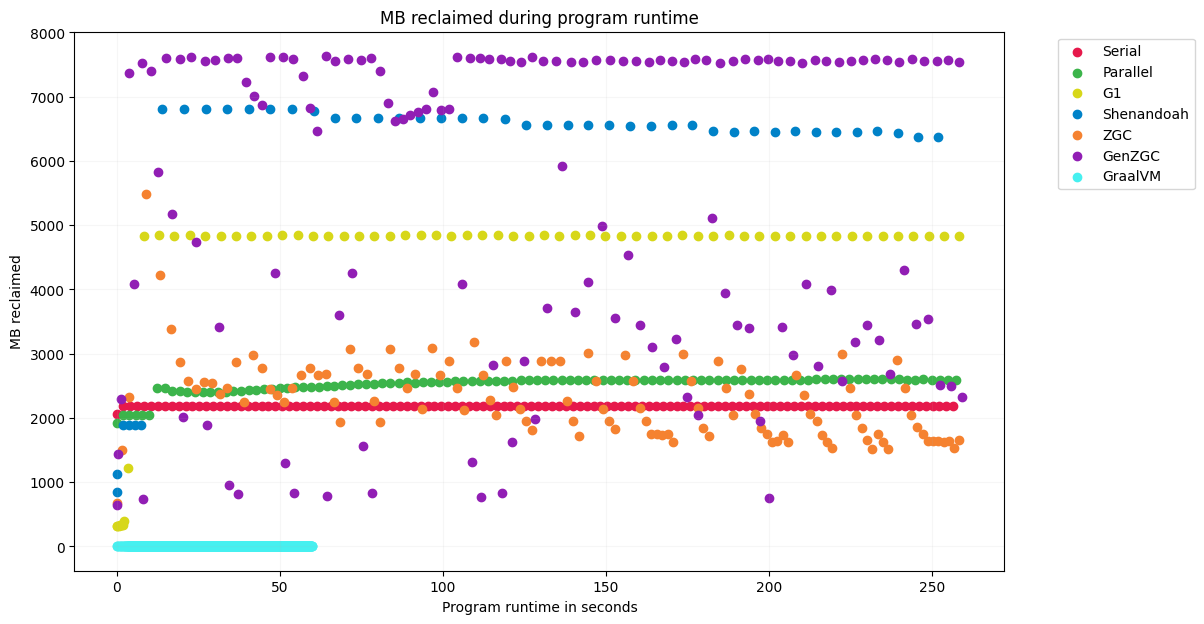

In [11]:
from src.graphing.plotting import plot_reclaimed_bytes

# Define a filter to confirm both automatically parsed regions for heap space are present
def gc_values_present(row):
    if "HeapBeforeGC" in row and "HeapAfterGC":
        if row["HeapBeforeGC"] != None and row["HeapAfterGC"] != None:
            return True
    return False

plot = plot_reclaimed_bytes(gc_event_dataframes, filter_by = gc_values_present, labels = labels)
plot.set_title("MB reclaimed during program runtime")
plot.set_ylabel("MB reclaimed")
plot.set_xlabel("Program runtime in seconds")
plot.grid(alpha = 0.1)

## 10. Heap Allocation Rate

Calculates the heap allocation rate in MB per second between garbage collection phases. Each pair of GC phases can be a data point, or allocation rate can be determined over a specified time interval in seconds.  Calculates both the AVERAGE and nth percentile allocation rate over a time interval. More explanation can be found here: 
[help](./README.md#10-heap-allocation-rate)

Text(0, 0.5, 'Allocation rate in MB per second')

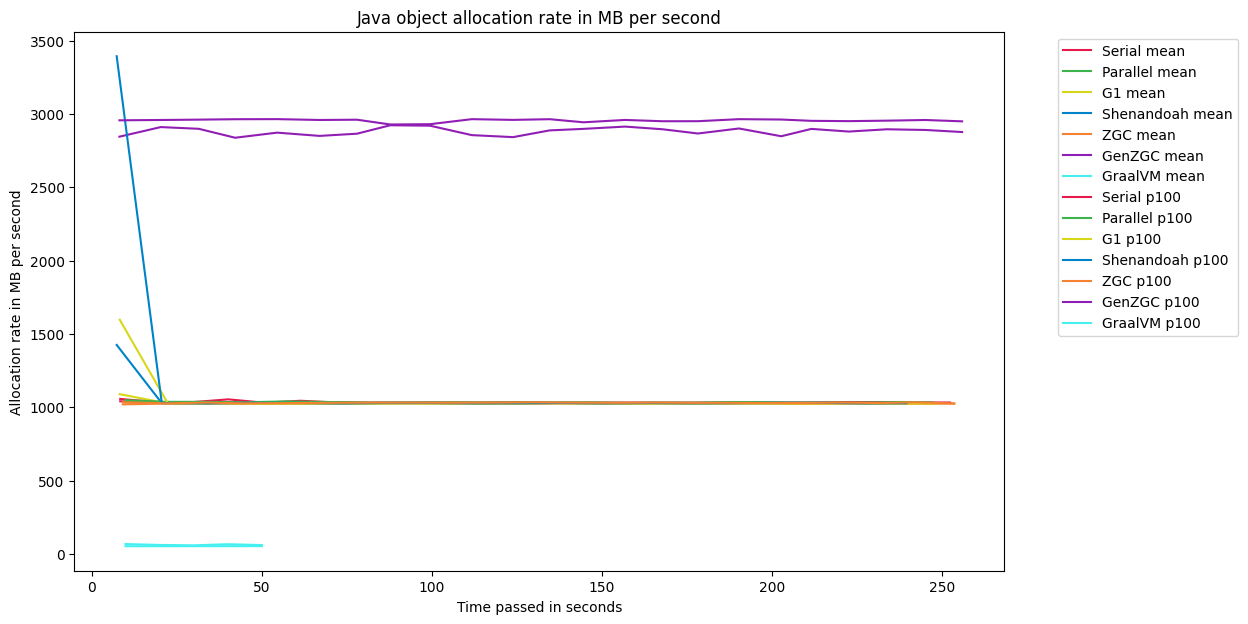

In [12]:
from src.graphing.plotting import allocation_rate
def diff_in_entries_filter(row):
    if "HeapBeforeGC" in row and "HeapAfterGC" in row:
        if row["HeapBeforeGC"] and row["HeapAfterGC"]:
            return True
    return False

interval_seconds = 10
percentile = 100

plot = allocation_rate(gc_event_dataframes,
                             filter_by = diff_in_entries_filter,
                             interval_duration= interval_seconds,
                             labels = [label + " mean" for label in labels],
                             line_graph=True)
plot = allocation_rate(gc_event_dataframes,
                             filter_by = diff_in_entries_filter,
                             interval_duration= interval_seconds,
                             labels = [label +" p" + str(percentile) for label in labels],
                             percentile = percentile,
                             plot = plot,
                             line_graph=True)                           
plot.set_title("Java object allocation rate in MB per second")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Allocation rate in MB per second")

# Section C : Code Cache Analysis
--- 


## 11. Percentage Used and Max-Used in Each Code Heap

Generates three plots for the percentage `used` and `max-used` in each code heap during the program runtime. More information can be found [here](./README.md#11-percentage-used-in-each-code-heap).

_`used`: The size of code heap memory that is actually in use._ \
_`max-used`: The maximum size that the code heap memory has grown to since the beginning of the program runtime. This will include any free memory in the code heap that was at some point in use._

### a. Non-profiled nmethods

/Users/bmathiske/git/GCGC/src/notebooks/../../src/graphing/plotting.py:79: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plot.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
/Users/bmathiske/git/GCGC/src/notebooks/../../src/graphing/plotting.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plot.legend(bbox_to_anchor=(1.05, 1), loc="upper left")


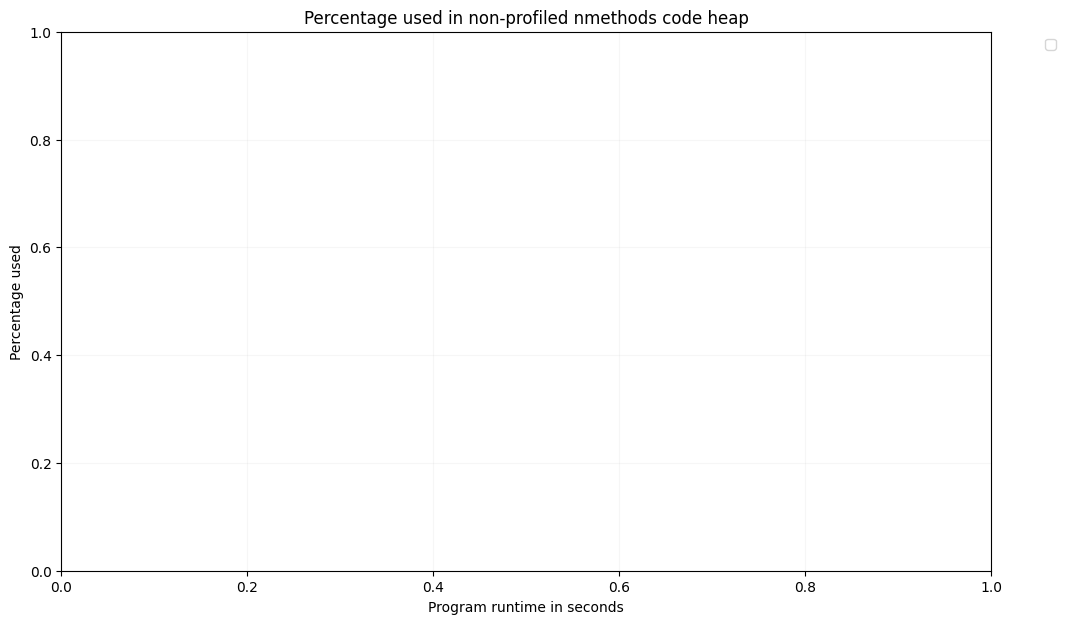

In [13]:
def non_profiled_nmethods_code_heap_percent_used_filter(row):
    if ("NonProfiledNMethodsCodeHeapPercentUsed" in row) and (row["NonProfiledNMethodsCodeHeapPercentUsed"] != None):
        return True
    return False

plot = plot_line(gc_event_dataframes,
                 filter_by = non_profiled_nmethods_code_heap_percent_used_filter,
                 labels = [label + " used" for label in labels],
                 column = "NonProfiledNMethodsCodeHeapPercentUsed")


def non_profiled_nmethods_code_heap_percent_max_used_filter(row):
    if ("NonProfiledNMethodsCodeHeapPercentMaxUsed" in row) and (row["NonProfiledNMethodsCodeHeapPercentMaxUsed"] != None):
        return True
    return False

plot = plot_scatter(gc_event_dataframes,
                 filter_by = non_profiled_nmethods_code_heap_percent_max_used_filter,
                 labels = [label + " max-used" for label in labels],
                 column = "NonProfiledNMethodsCodeHeapPercentMaxUsed",
                 plot = plot)


plot.set_title("Percentage used in non-profiled nmethods code heap")
plot.set_ylabel("Percentage used")
plot.set_xlabel("Program runtime in seconds")
plot.grid(alpha = 0.1)

### b. Profiled nmethods

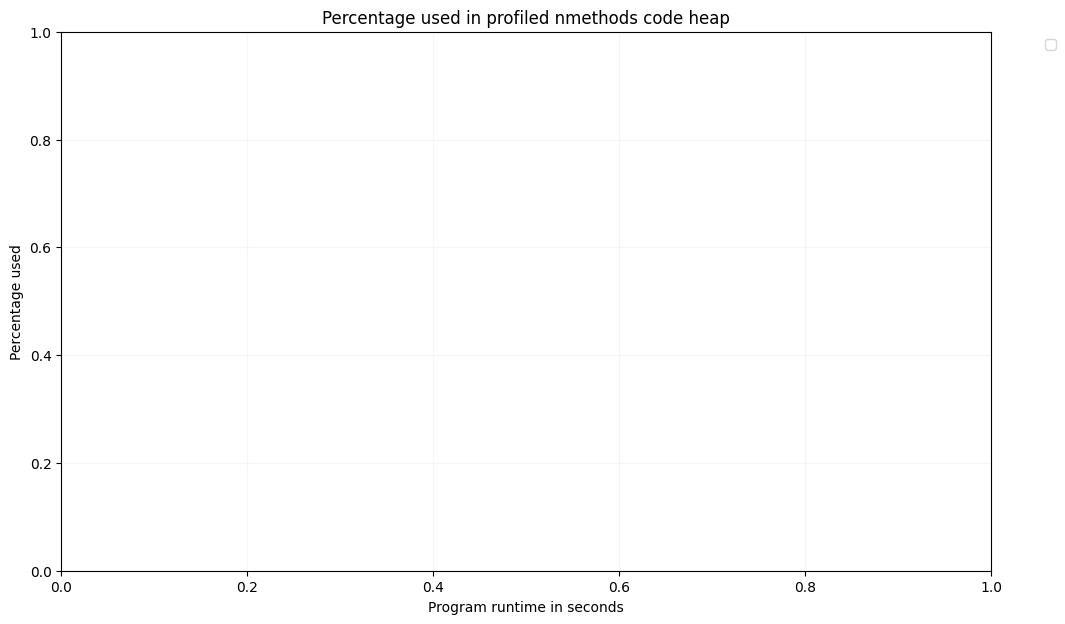

In [14]:
def profiled_nmethods_code_heap_percent_used_filter(row):
    if ("ProfiledNMethodsCodeHeapPercentUsed" in row) and (row["ProfiledNMethodsCodeHeapPercentUsed"] != None):
        return True
    return False

plot = plot_line(gc_event_dataframes,
                 filter_by = profiled_nmethods_code_heap_percent_used_filter,
                 labels = [label + " used" for label in labels],
                 column = "ProfiledNMethodsCodeHeapPercentUsed")


def profiled_nmethods_code_heap_percent_max_used_filter(row):
    if ("ProfiledNMethodsCodeHeapPercentMaxUsed" in row) and (row["ProfiledNMethodsCodeHeapPercentMaxUsed"] != None):
        return True
    return False

plot = plot_scatter(gc_event_dataframes,
                 filter_by = profiled_nmethods_code_heap_percent_max_used_filter,
                 labels = [label + " max-used" for label in labels],
                 column = "ProfiledNMethodsCodeHeapPercentMaxUsed",
                 plot = plot)


plot.set_title("Percentage used in profiled nmethods code heap")
plot.set_ylabel("Percentage used")
plot.set_xlabel("Program runtime in seconds")
plot.grid(alpha = 0.1)

### c. Non-nmethods

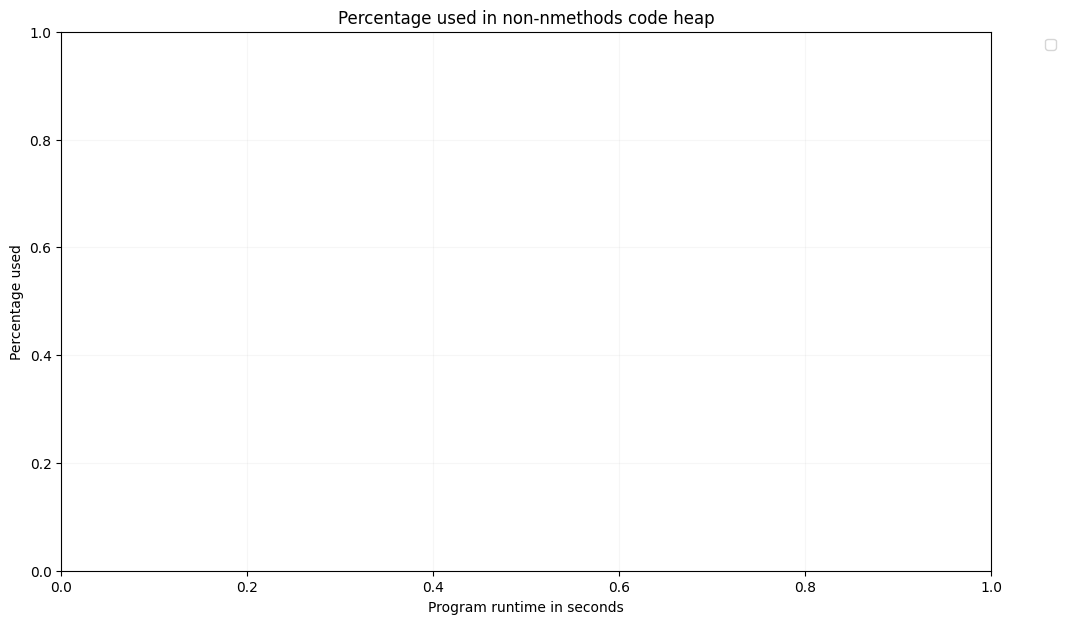

In [15]:
def non_nmethods_code_heap_percent_used_filter(row):
    if ("NonNMethodsCodeHeapPercentUsed" in row) and (row["NonNMethodsCodeHeapPercentUsed"] != None):
        return True
    return False

plot = plot_line(gc_event_dataframes,
                 filter_by = non_nmethods_code_heap_percent_used_filter,
                 labels = [label + " used" for label in labels],
                 column = "NonNMethodsCodeHeapPercentUsed")


def non_nmethods_code_heap_percent_max_used_filter(row):
    if ("NonNMethodsCodeHeapPercentMaxUsed" in row) and (row["NonNMethodsCodeHeapPercentMaxUsed"] != None):
        return True
    return False

plot = plot_scatter(gc_event_dataframes,
                 filter_by = non_nmethods_code_heap_percent_max_used_filter,
                 labels = [label + " max-used" for label in labels],
                 column = "NonNMethodsCodeHeapPercentMaxUsed",
                 plot = plot)


plot.set_title("Percentage used in non-nmethods code heap")
plot.set_ylabel("Percentage used")
plot.set_xlabel("Program runtime in seconds")
plot.grid(alpha = 0.1)

## 12. Code Cache Flushing Rate

Genarates a plot for the number of code cache flushes per second between flushing events. More information can be found [here](./README.md#12-code-cache-flushing-rate).

/Users/bmathiske/git/GCGC/src/notebooks/../../src/graphing/code_cache_flushing_rate.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plot.legend(bbox_to_anchor=(1.05, 1), loc="upper left")


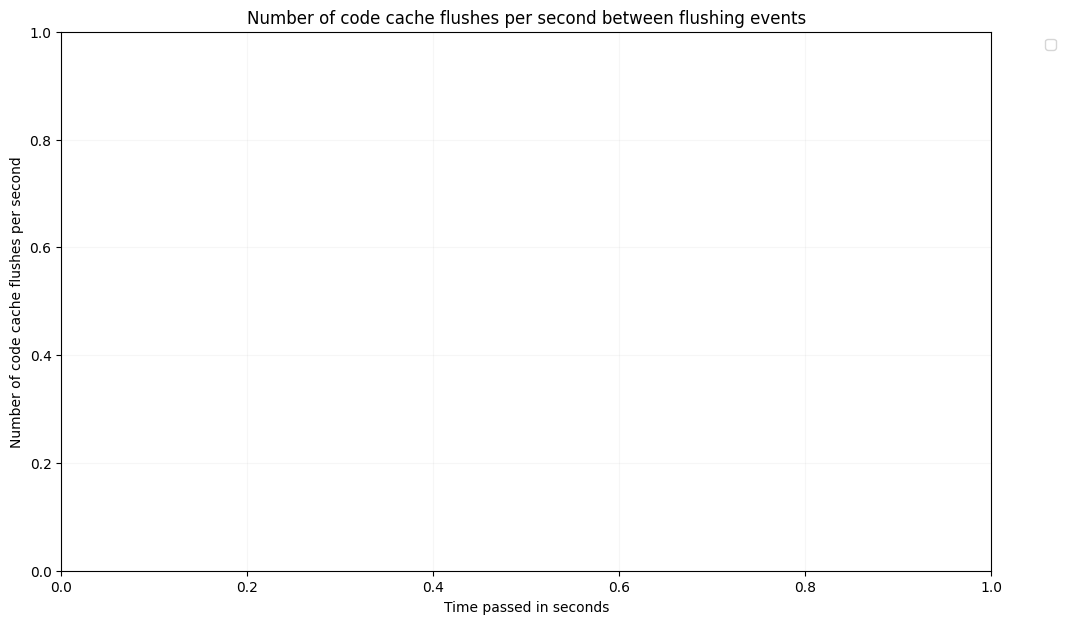

In [16]:
from src.graphing.plotting import plot_code_cache_flushing_rate

plot = plot_code_cache_flushing_rate(gc_event_dataframes,
                             labels = labels,
                             line_graph = True)
plot.set_title("Number of code cache flushes per second between flushing events")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Number of code cache flushes per second")
plot.grid(alpha = 0.1)

# Section D : Metaspace Analysis
--- 


## 13. Used Metaspace After GC

Generates a plot for the used metaspace in MB after GC during program runtime. More information can be found [here](./README.md#13-used-metaspace-after-gc).

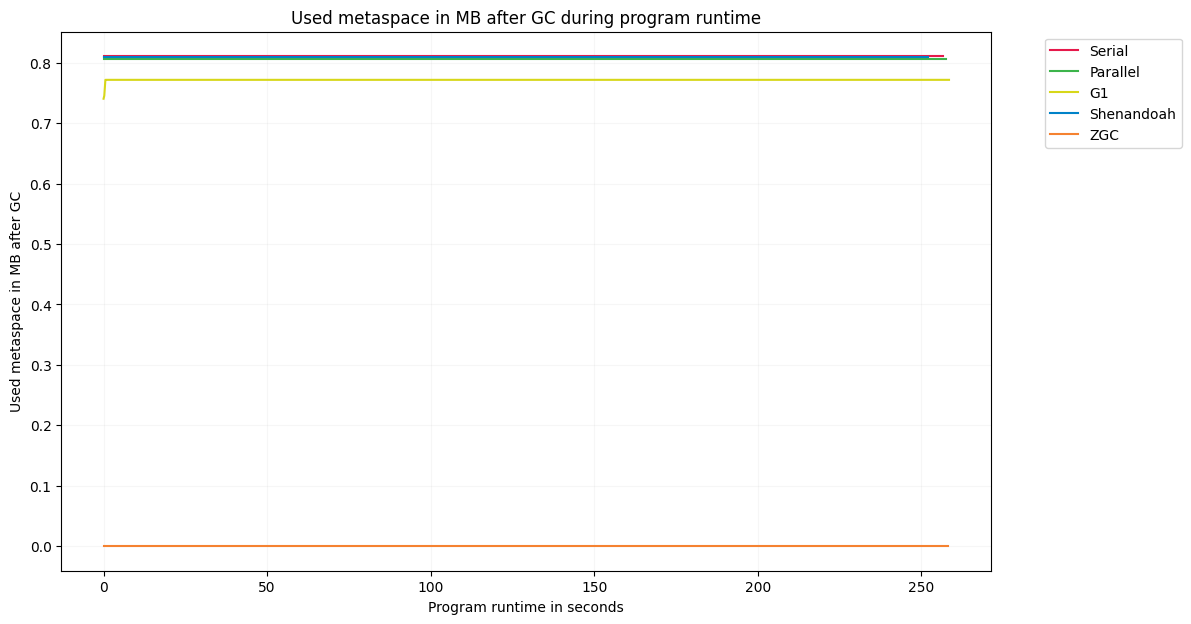

In [17]:
def used_metaspace_after_gc_filter(row):
    if ("UsedMetaspaceAfterGC" in row) and (row["UsedMetaspaceAfterGC"] != None):
        return True
    return False

plot = plot_line(gc_event_dataframes,
            filter_by = used_metaspace_after_gc_filter,
            labels = labels, 
            column = "UsedMetaspaceAfterGC")
plot.set_title("Used metaspace in MB after GC during program runtime")
plot.set_ylabel("Used metaspace in MB after GC")
plot.set_xlabel("Program runtime in seconds")
plot.grid(alpha = 0.1)

# Section E : Summaries
--- 


## 14. Concurrent durations during runtime

Plots all times where the garbage collector ran concurrently with the live application.  Note: Sometimes this plot will be blank, if no concurrent events ran. To find out more, read 
[here](./README.md#14-concurrent-durations-during-runtime)

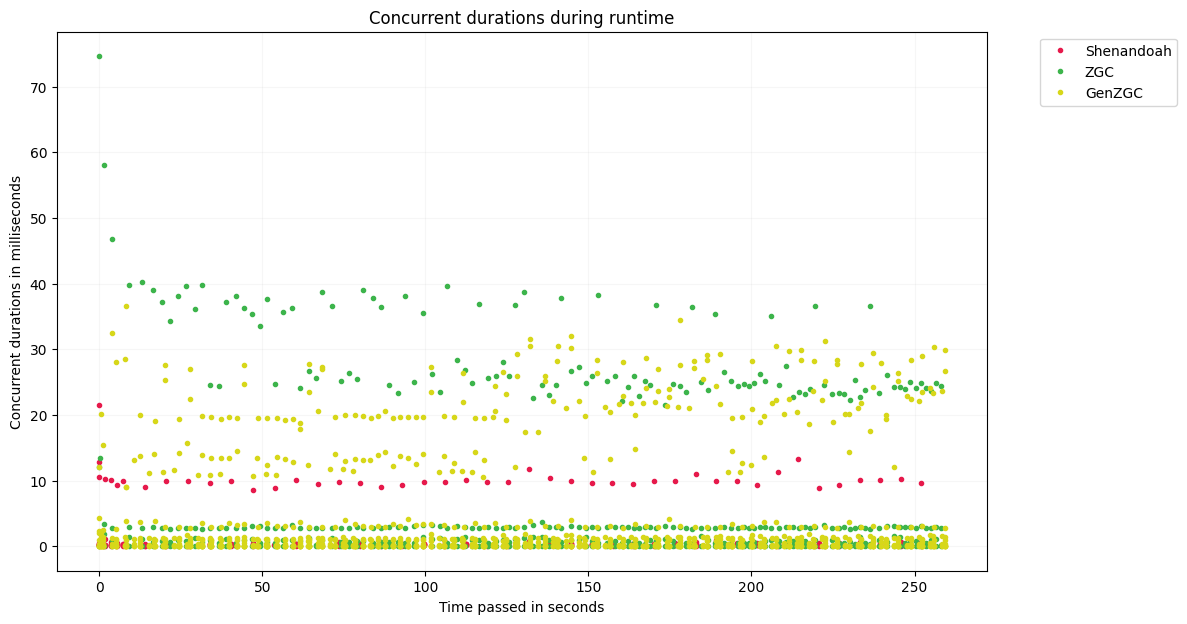

In [18]:
# Define a filter for capturing concurrent_only values
def concurrent_only(row):
    if "EventType" in row:
        if row["EventType"] == "Concurrent":
            return True
    return False

plot = plot_scatter(gc_event_dataframes, labels=labels, filter_by= concurrent_only)
_ = plot.set_title("Concurrent durations during runtime")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Concurrent durations in milliseconds")
plot.grid(alpha = 0.1)

 ## 15. Sum of event durations, grouped by EventType

 Creates a bar graph plotting the sum of event durations. This graph lets you determine which phases of GC the applications threads spend time in. It is recommended you switch the optional parameter group_by to equal "EventName" for a more detailed breakdown of time spent.

        group_by = "EventName"

 More information can be found [here](./README.md#15-sum-of-event-durations-grouped-by-eventtype)

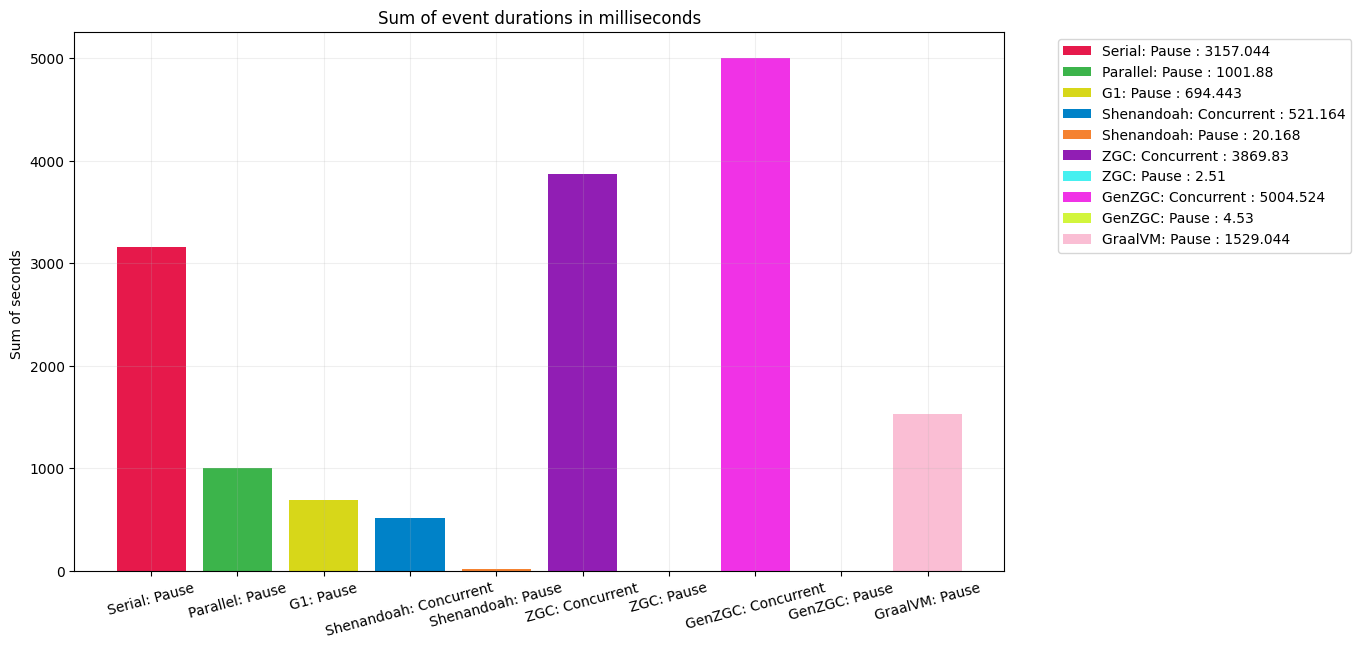

In [19]:
from src.graphing.plotting import plot_bar_sum
# Define a filter to confirm there is an event duration.
def duration_present(row):
    if "Duration_milliseconds" in row:
        if row["Duration_milliseconds"]:
            return True
    return False
    
# The grouping by eventtype means that every matching event name lives in one group. 
# Example: "Concurrent" events are a group, and "Pause" events are a group
plot = plot_bar_sum(gc_event_dataframes, group_by = "EventType", filter_by = duration_present, labels= labels)
_ = plot.set_title("Sum of event durations in milliseconds")
_ = plot.set_ylabel("Sum of seconds ")
_ = plt.xticks(rotation = 15)
plot.grid(alpha = 0.2)

## 16. Pauses summary 

Creates a table on pause information in ASCII format. Note: Each discrete pause event is recorded, such that one GC phase may have multiple pauses. To help keep track of what type of GC pause is happening, it is recommended you use the optional parameter below: 

    group_by = "EventName"

For a more detailed explanation on this table, view the [documentation here](./README.md#16-pauses-summary)

In [20]:
from src.graphing.plotting import plot_summary

# Print summary in ASCII format
print("\t\t\tPauses during runtime\n------------------------------------------------------------------------------------------------------------------")
plot_summary(gc_event_dataframes, 
       filter_by = pauses_only,
       labels= labels,
       throughput=True)

			Pauses during runtime
------------------------------------------------------------------------------------------------------------------
  summary (ms)   | Event Count   | Max Duration  | Sum Duration  | Mean Duration | Std Dev.      | Throughput    |
------------------------------------------------------------------------------------------------------------------
Serial          |      122.0000 |      101.0630 |     3157.0440 |       25.8774 |       11.2083 |       98.7700 % 
Parallel        |      106.0000 |       42.1340 |     1001.8800 |        9.4517 |        5.7267 |       99.6100 % 
G1              |       63.0000 |       25.2240 |      694.4430 |       11.0229 |        3.4568 |       99.7300 % 
Shenandoah      |       88.0000 |        0.6060 |       20.1680 |        0.2292 |        0.0930 |       99.9900 % 
ZGC             |      348.0000 |        0.0480 |        2.5100 |        0.0072 |        0.0043 |      100.0000 % 
GenZGC          |      583.0000 |        0.0280 |      

## 17. Pause percentiles

Creates an ASCII table showing the percentile pause times in miliseconds for GC pauses. It is recommended you experiment with the optional parameters below:

    group_by = "EventName"

This table is helpful for identifiying acceptable latency ranges for your program.

Find more [help here](./README.md#17-pause-percentiles)

In [21]:
from src.graphing.plotting import plot_percentiles

print("\t\t\tPause percentiles during runtime\n----------------------------------------------------------------------------------")
plot_percentiles(gc_event_dataframes, 
       filter_by = pauses_only,
       labels= labels)

			Pause percentiles during runtime
----------------------------------------------------------------------------------
Legend (All timing in milliseconds) : 
A | Serial
B | Parallel
C | G1
D | Shenandoah
E | ZGC
F | GenZGC
G | GraalVM
-------------------------------------------------------------------------------------------------
    |                50% |                95% |                99% |             99.99% | 
------------------------------------------------------------------------------------------------
  A |            22.5110 |            40.7488 |            84.2523 |           100.9144 | 
  B |             7.8910 |            15.2040 |            40.1063 |            42.1134 | 
  C |             9.7270 |            19.4765 |            24.8917 |            25.2207 | 
  D |             0.2175 |             0.3792 |             0.5286 |             0.6052 | 
  E |             0.0070 |             0.0100 |             0.0275 |             0.0476 | 
  F |             0.0070

## 18. Mean & Sum of Event Durations

Plots the average time spent in each EventType (either STW pauses or Concurrent) as an average, or a sum. This can help you identify how your program is spending most of its time. Note that the plotting functions are called twice in this cell, to generate the two unique plots. It is recommended you experiment with the `filter_by` and `group_by` if you are intrested to compare compare sums and averages of groups on other plots.

[help](./README.md#18-mean-and-sum-of-event-durations)

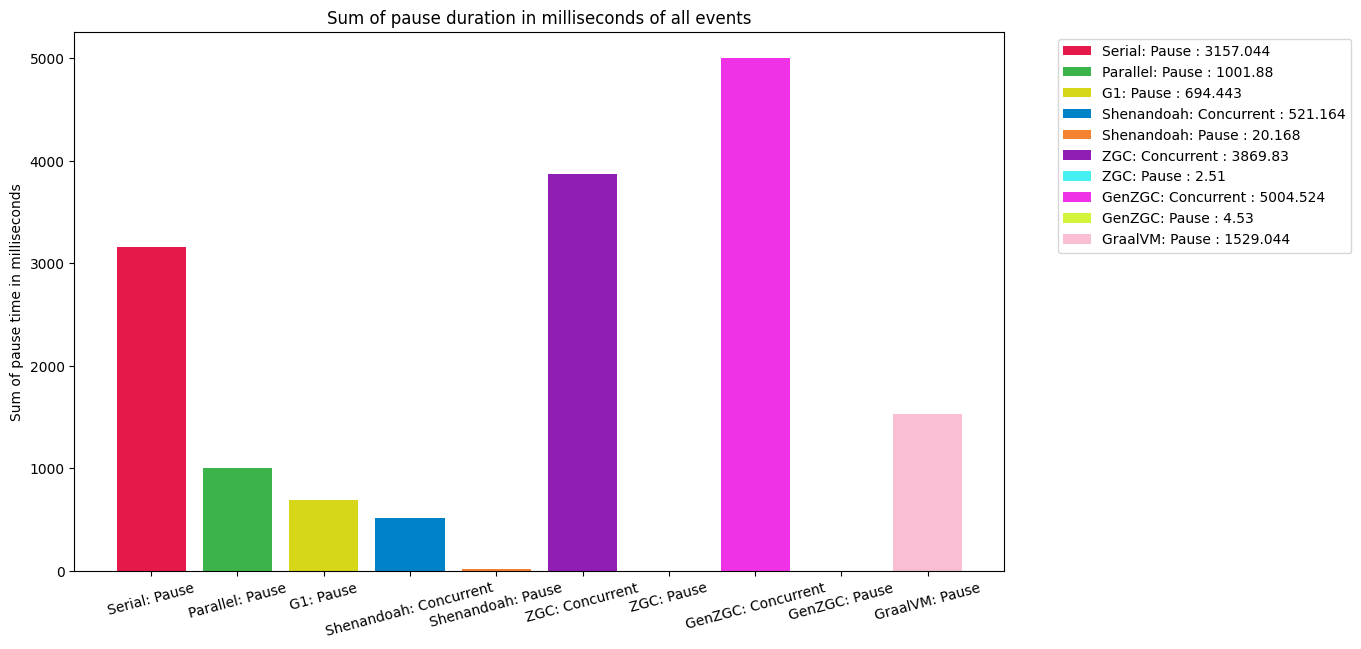

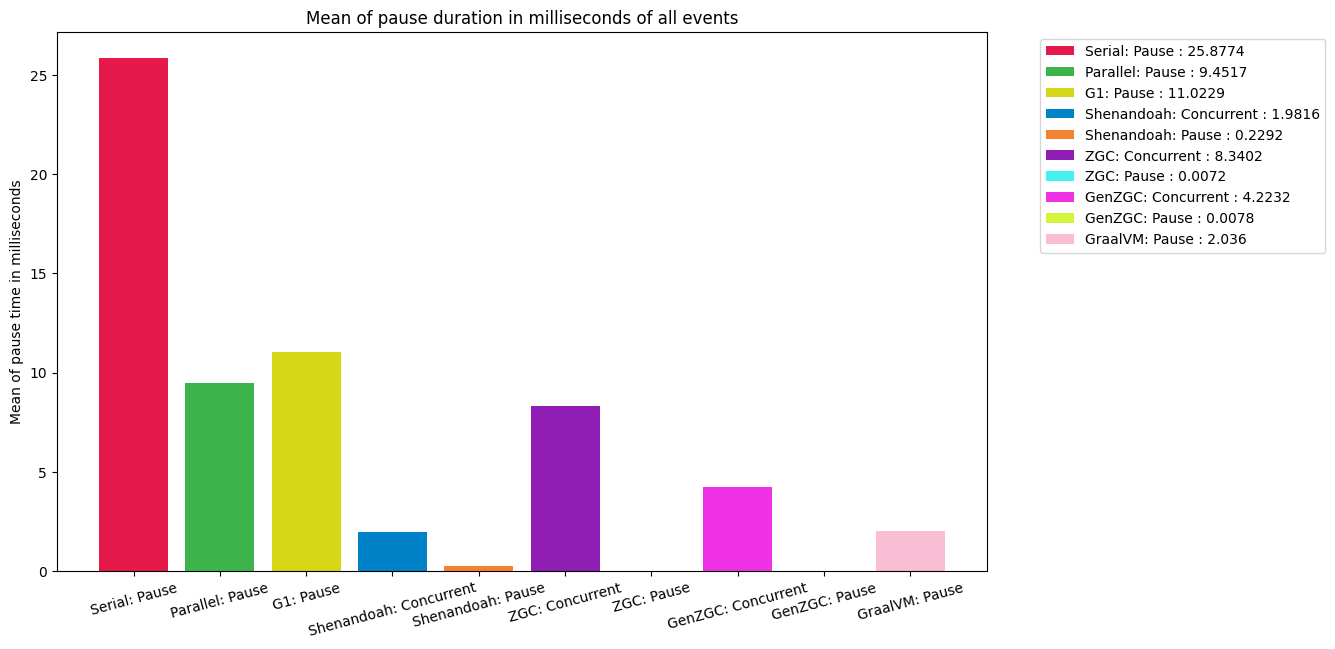

In [22]:
from src.graphing.plotting import plot_bar_sum, plot_bar_avg
# Define a filter that allows for either Concurrent or Pause eventTypes.
def concurrent_or_pauses(row):
    if "EventType" in row:
        if row["EventType"] == "Concurrent" or row["EventType"] == "Pause":
            return True
    return False
# Sum time during program runtime
plot = plot_bar_sum(gc_event_dataframes,
                    group_by = "EventType", 
                    labels = labels, 
                    filter_by = concurrent_or_pauses)
plot.set_title("Sum of pause duration in milliseconds of all events")
plot.set_ylabel("Sum of pause time in milliseconds")
_ = plt.xticks(rotation = 15) # Rotates the names on the plots.

#Averages
plot = plot_bar_avg(gc_event_dataframes, 
                    group_by = "EventType", 
                    labels = labels, 
                    filter_by = concurrent_or_pauses)
plot.set_title("Mean of pause duration in milliseconds of all events")
plot.set_ylabel("Mean of pause time in milliseconds")
_ = plt.xticks(rotation = 15)

## 19. Pause Frequencies Histogram

Creates a histogram of pause frequencies. 
[help](./README.md#19-pause-frequencies-histogram)

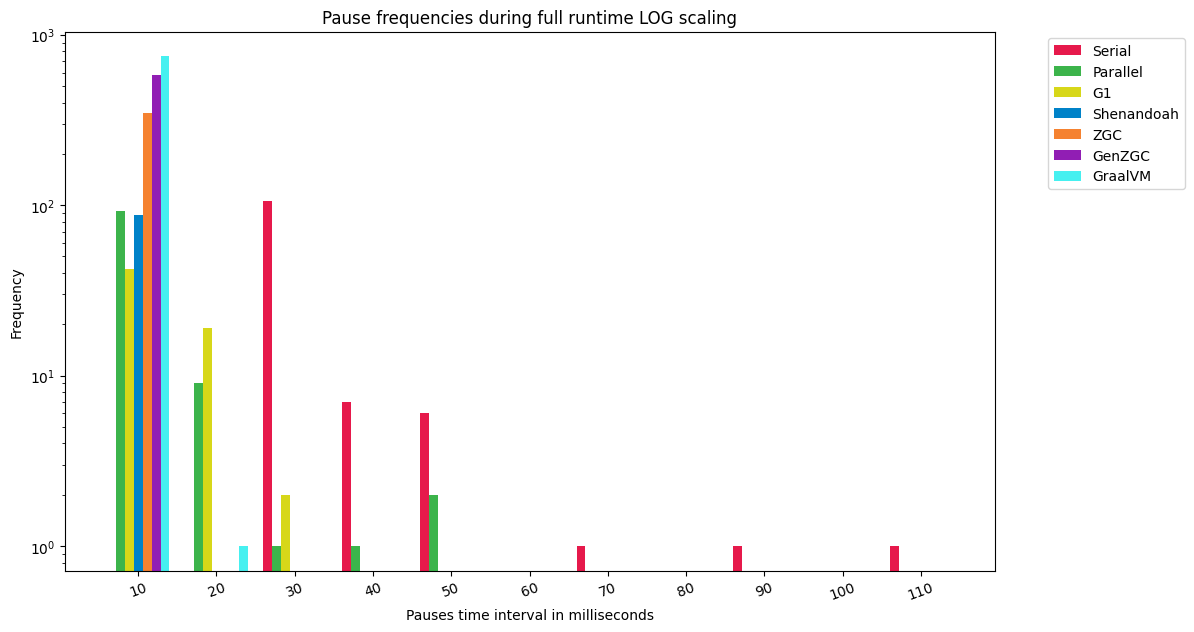

In [23]:
from src.graphing.plotting import plot_frequency_intervals

# All intervals are in seconds
plot = plot_frequency_intervals(gc_event_dataframes,
                         filter_by = pauses_only,
                         interval_duration = 10,                          
                         labels = labels)
                         
_ = plt.xticks(rotation = 20)
plot.set_xlabel("Pauses time interval in milliseconds")
plot.set_ylabel("Frequency")
plot.set_title("Pause frequencies during full runtime LOG scaling")
plot.set_yscale("log")


## 20. Number of times GC invoked over time intervals

Given an interval_duration in seconds, counts the number of discrete GC phases for each interval. More information 
[here](./README.md#20-number-of-times-gc-invoked-over-time-intervals)

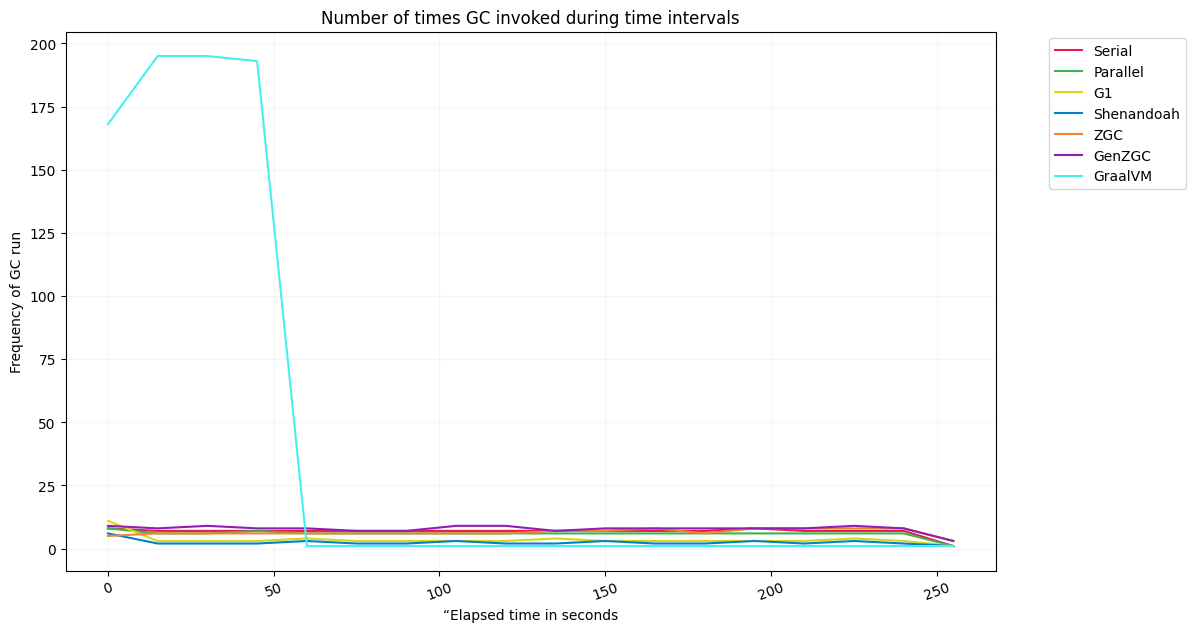

In [24]:
from src.graphing.plotting import plot_frequency_of_gc_intervals
interval_duration = 15
plot = plot_frequency_of_gc_intervals(gc_event_dataframes, 
                                      filter_by = pauses_only, 
                                      interval_duration = interval_duration,
                                      labels = labels)
plot.set_ylabel("Frequency of GC run")
plot.set_xlabel("“Elapsed time in seconds")
plot.set_title("Number of times GC invoked during time intervals")
plot.grid(alpha = 0.1)
_ = plt.xticks(rotation = 20)


## 21. Example of importing external data for analysis.

### No analysis is provided here:
This example is just to show some of the syntax required for using an external data set with differenly labeled columns.

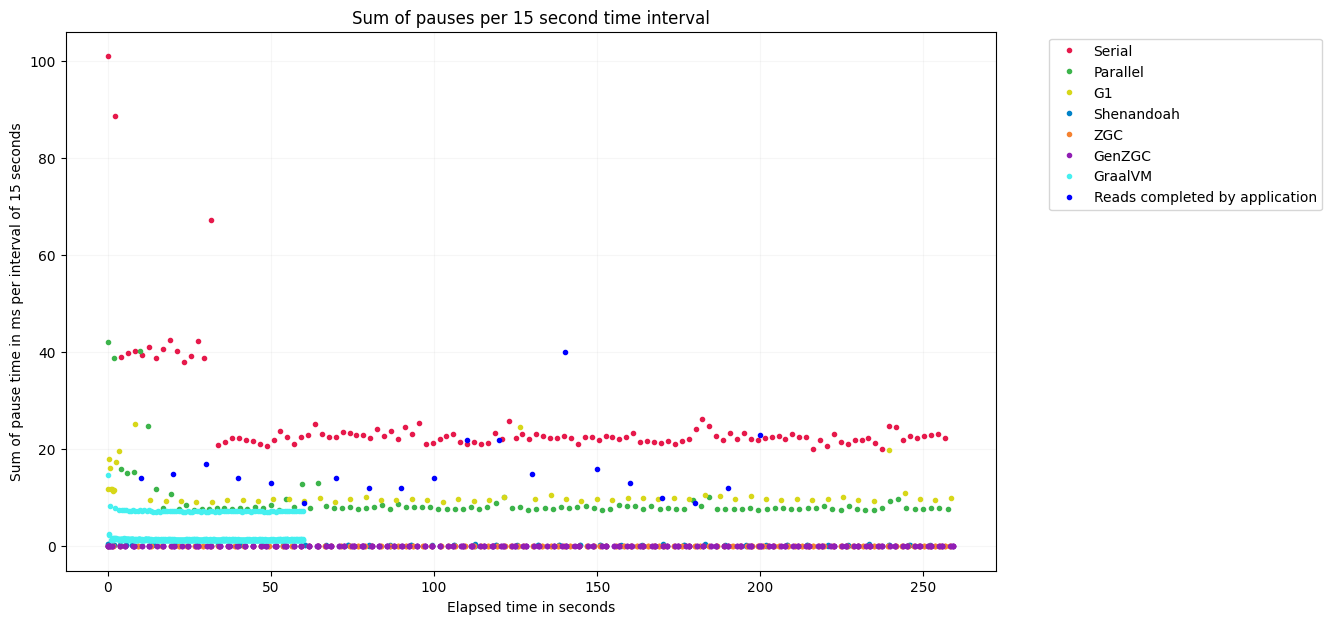

In [25]:
from src.graphing.plotting import plot_sum_pause_intervals

# First, normally plot a scatterplot
plot = plot_scatter(gc_event_dataframes, filter_by = pauses_only, labels = labels)

plot.set_title("Sum of pauses per " + str(interval_duration) + " second time interval")
plot.set_ylabel("Sum of pause time in ms per interval of " + str(interval_duration) + " seconds", )
plot.set_xlabel("Elapsed time in seconds")
plot.grid(alpha = 0.1)

# Import the CSV data, then plot in the same cell using the
# same 'plot' object returned from the above graphing function.    
csv_data = pd.read_csv("../../datasets/example_external_data.csv")

# Plot the data.
plot = plot_scatter([csv_data], # must be a list
                    column = "Reads Completed",
                    column_timing="Time Seconds",
                    labels = ["Reads completed by application"],
                    plot = plot,
                    colors = ["blue"])